In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
sns.set_palette("Set2")
palette = sns.color_palette("Set2")

import pycountry
import pycountry_convert as pc

import folium

from datetime import datetime

from src.utils.locationHelper import LocationHelper
from src.utils.preProcessingHelper import PreProcessRatings

from pandas.api.types import CategoricalDtype

from scipy.stats import norm, f_oneway, shapiro, kruskal
import random


np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
reviews_df = pd.read_csv("data/tims_data/beerAdvocateReviews.csv") # subset of ratings containing more fields
ratings_df = pd.read_csv("data/tims_data/beerAdvocateRatings.csv") 

# only US
reviews_df_usa = reviews_df[reviews_df["country_code3"] == "USA"]
ratings_df_usa = ratings_df[ratings_df["country_code3"] == "USA"]



### Which data should we use for our investigation?
Can we find special behaviour for some year?

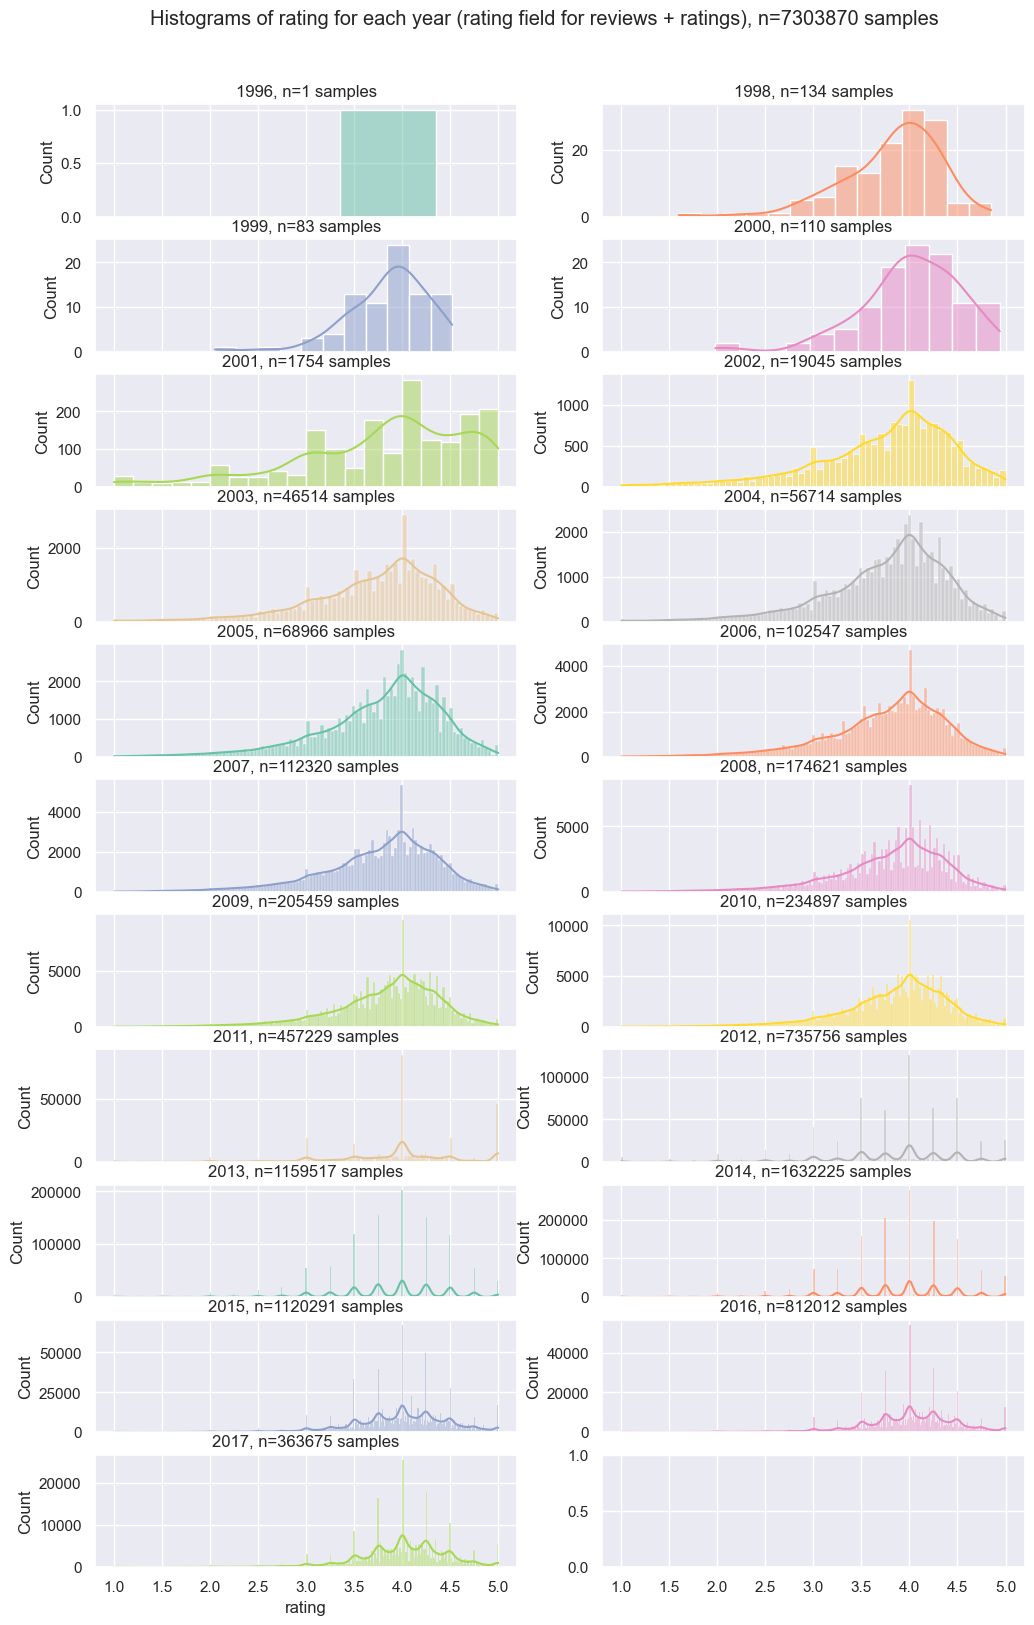

In [12]:
years = np.sort(ratings_df_usa["year"].dropna().unique())
fig, ax = plt.subplots(int(np.ceil(len(years)/2)), 2, figsize= (12, 19), sharex=True)
ax = ax.flatten()
fig.suptitle(f"Histograms of rating for each year (rating field for reviews + ratings), n={ratings_df_usa.shape[0]} samples", y=0.93)
for i, year in enumerate(years):
    year_df = ratings_df_usa[ratings_df_usa["year"] == year]
    h = sns.histplot(year_df , x = "rating", kde=True, ax=ax[i], color=palette[i%len(palette)])
    h.set_title(f'{int(year)}, n={year_df.shape[0]} samples')

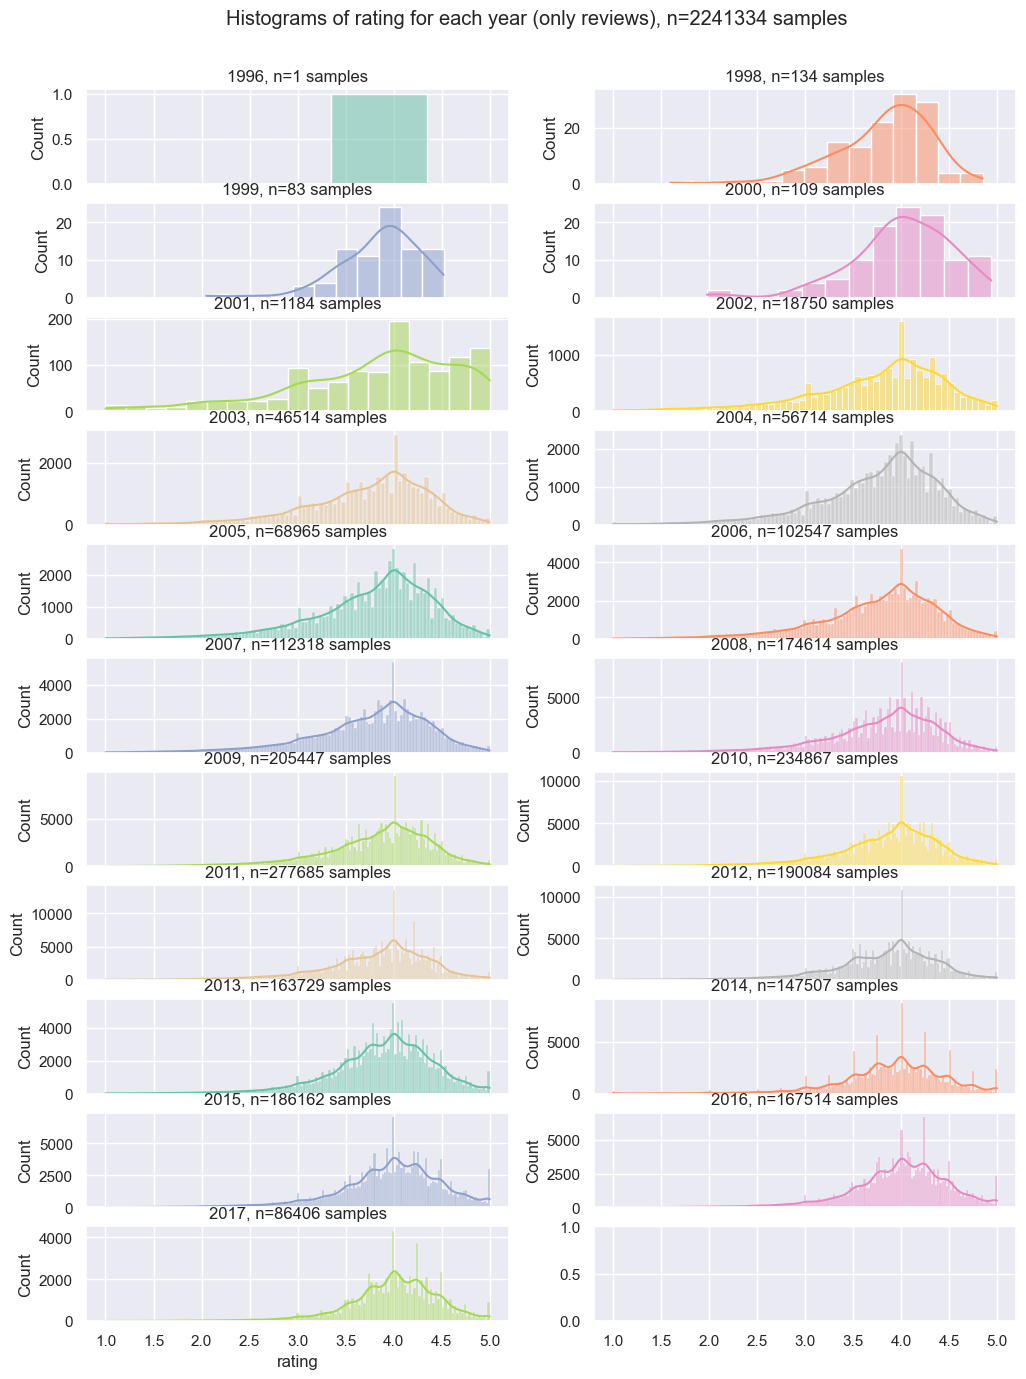

In [13]:
years = np.sort(reviews_df_usa["year"].dropna().unique())
fig, ax = plt.subplots(int(np.ceil(len(years)/2)), 2, figsize= (12, 16), sharex=True)
ax = ax.flatten()
fig.suptitle(f"Histograms of rating for each year (only reviews), n={reviews_df_usa.shape[0]} samples", y=0.93)
for i, year in enumerate(years):
    year_df = reviews_df_usa[reviews_df_usa["year"] == year]
    h = sns.histplot(year_df , x = "rating", kde=True, ax=ax[i], color=palette[i%len(palette)])
    h.set_title(f'{int(year)}, n={year_df.shape[0]} samples')

To make things easier and more robust to changes differences of rating systems that are eventually reflected in the rating, we took the decision to do our investigation for one platform. As BeerAdvocate has more and more fine grained data, we concluded to go for BeerAdvocate in the US. BeerAdvocates data mainly stems from the US and we have a further partitioning in the states.  


Looking at the plots we see that starting from 2002 the number of ratings start to rise and is more similar to the other years. We conclude that the rating system changed. To not let old data screw our results, we get rid of the data before 2002.

Furthermore, there are ratings and reviews where the reviews are a subset of the ratings. The final rating for reviews, which is only a small subset we have, is calculated by a weighted mean over different attributes. The rating on the other hand is just one number with steps of 0.25.

In [ ]:
#TODO: analysis per month